# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj probowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

(-0.5, 556.5, 416.5, -0.5)

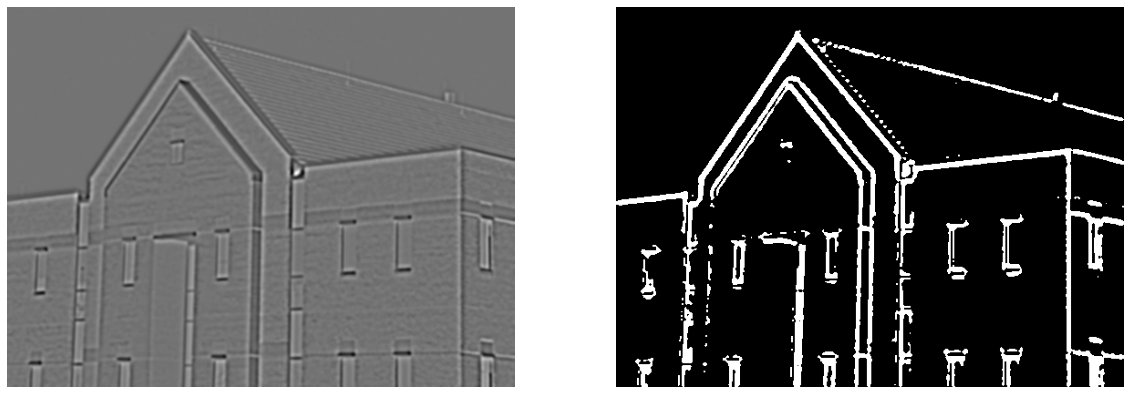

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

def crossing(LoG, thr):
    IC = LoG.copy()
    X,Y = IC.shape
    for i in range (1, X-1):
        for j in range (1, Y-1):
            row_up = i - 1
            row_down = i + 2

            col_left = j - 1
            col_right = j + 2

            S = np.array(LoG[row_up : row_down, col_left : col_right])       
            maxi = np.max(S)
            mini = np.min(S)

            if not (maxi > 0 and mini > 0 or maxi < 0 and mini < 0):
                if LoG[i,j] > 0:
                    IC[i,j] += abs(mini)
                elif LoG[i,j] < 0:
                    IC[i,j] = abs(IC[i,j]) + maxi
                    
    IC = IC/IC.max() * 255

    ICP = np.uint8((IC > thr)*255)
    ICB = cv2.medianBlur(ICP, 3)
    
    return ICB  


if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate
  
I = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)
I2 = cv2.GaussianBlur(np.float32(I), (11,11), 0)
I3 = cv2.Laplacian(I2, cv2.CV_32F)

figFale, axsFale = plt.subplots(1,2)
figFale.set_size_inches(20,10)

axsFale[0].imshow(I3, 'gray')
axsFale[0].axis('off')
axsFale[1].imshow(crossing(I3, 30), 'gray')
axsFale[1].axis('off')




## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

(-0.5, 556.5, 416.5, -0.5)

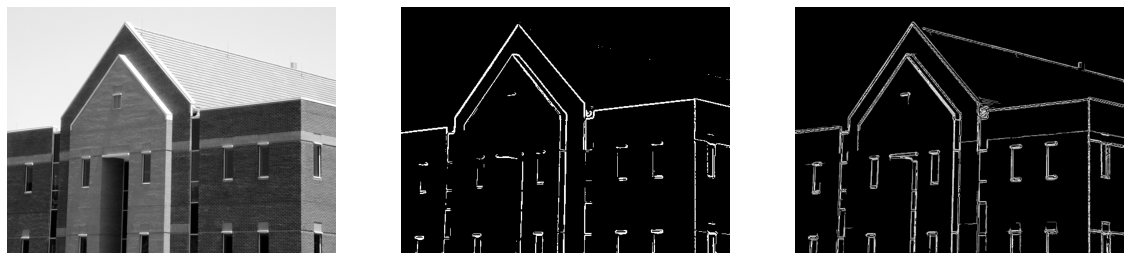

In [2]:
def fgaussian(size, sigma):
    m = n = size
    h, k = m//2, n//2
    x, y = np.mgrid[-h:h+1, -k:k+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g /g.sum() 
    
def pixel(I, F):
    IF = np.zeros(I.shape)
    for i in range (I.shape[0]):
        for j in range (I.shape[1]):
            IF[i,j] = I[i,j]*F[i,j]
            
    return (np.sum(IF)/np.sum(F)) 
                  
def conv(I):
    window = 3
    w = window//2
    sigma = 3
    f1 = fgaussian(window, sigma)
    
    IC = I.copy()
    X,Y = IC.shape
    for i in range (w, X-w):
        for j in range (w, Y-w):
                row_up = i - w
                row_down = i + w +1

                col_left = j - w
                col_right = j + w + 1

                temp = np.array(I[row_up : row_down, col_left : col_right])       
                IC[i,j] = pixel(temp, f1) 
    return IC

def kwant(M, a):
    X, Y = M.shape
    ID = np.zeros((X,Y), dtype=np.int32)
    angle = a * 180 / np.pi
    for i in range(1,X-1):
        for j in range(1,Y-1):
            if (-22.5 <= angle[i,j] < 22.5) or (-180 <= angle[i,j] <= -157.5) or (157.5 <= angle[i,j] <= 180):
                # poziom
                ID[i,j] = 1 

            elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
                #skośny prawy
                ID[i,j] = 2

            elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
                #pionowy
                ID[i,j] = 3

            elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
                #skośny lewy
                ID[i,j] = 4
    return ID

def nonmax(ID, M):
    IC = M.copy()
    X,Y = IC.shape
    for i in range (1, X-1):
        for j in range (1, Y-1): 
            if ID[i,j] == 1:
                if ID[i,j-1] > M[i,j] or ID[i,j+1] > M[i,j]:
                    IC[i,j] = 0
                else:
                    IC[i,j] = M[i,j]
            if ID[i,j] == 2:
                if ID[i-1,j+1] > M[i,j] or ID[i+1,j-1] > M[i,j]:
                    IC[i,j] = 0
                else:
                    IC[i,j] = M[i,j]
            if ID[i,j] == 3:
                if ID[i-1,j] > M[i,j] or ID[i+1,j] > M[i,j]:
                    IC[i,j] = 0
                else:
                    IC[i,j] = M[i,j]
            if ID[i,j] == 4:
                if ID[i-1,j-1] > M[i,j] or ID[i+1,j+1] > M[i,j]:
                    IC[i,j] = 0
                else:
                    IC[i,j] = M[i,j]
    return IC

def bina(I, low, high):
    lists = []
    X,Y = I.shape
    OD = np.zeros((X,Y))
    IC = np.zeros((X,Y))
    GNH = np.zeros((X,Y))
    GNL = np.zeros((X,Y))
    for i in range(X):
        for j in range(Y):
            if I[i,j] >= high:
                lists.append([i,j])
                GNH[i,j] = np.uint8(I[i,j] >= high)
            GNL[i,j] = np.uint8(((high > I[i,j]) and (I[i,j] >= low)))
    
    while lists:
        elem = lists.pop(0)
        if OD[elem[0],elem[1]] != 1:
            OD[elem[0],elem[1]] = 1
            IC[elem[0],elem[1]] = np.uint8(I[elem[0],elem[1]]) # lub 255
            if X-2>=elem[0]>=2 and Y-2>=elem[1]>=2:
                for i in range(elem[0] - 1, elem[0] + 2):
                    for j in range(elem[1] - 1, elem[1] + 2):
                        if GNL[i,j] == 1:
                            lists.append([i,j])         
            
    
    return IC, GNH          
                    



I = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)
I2 = conv(I)

grad_x = cv2.Sobel(I2, cv2.CV_32F, 1, 0, 3)
grad_y = cv2.Sobel(I2, cv2.CV_32F, 0, 1, 3)
M =  (grad_x**2 + grad_y**2)**0.5 
alfa = np.arctan2(grad_x, grad_y)

I3 = kwant(M, alfa)
I4 = nonmax(I3, M)
I5, GNH = bina(I4,90,200)

fig, axs = plt.subplots(1,3)
fig.set_size_inches(20,10)

axs[0].imshow(I, 'gray')
axs[0].axis('off')
axs[1].imshow(GNH, 'gray')
axs[1].axis('off')
axs[2].imshow(I5, 'gray')
axs[2].axis('off')



(-0.5, 556.5, 416.5, -0.5)

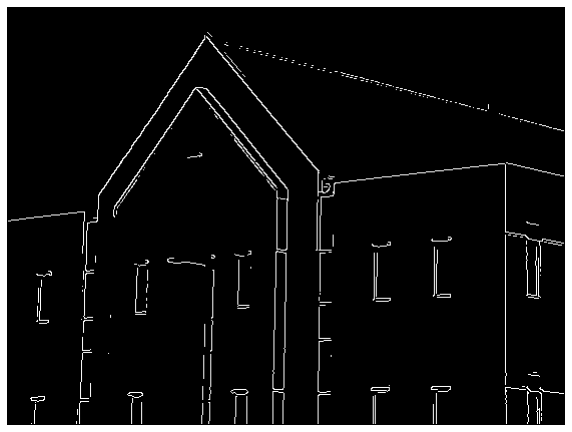

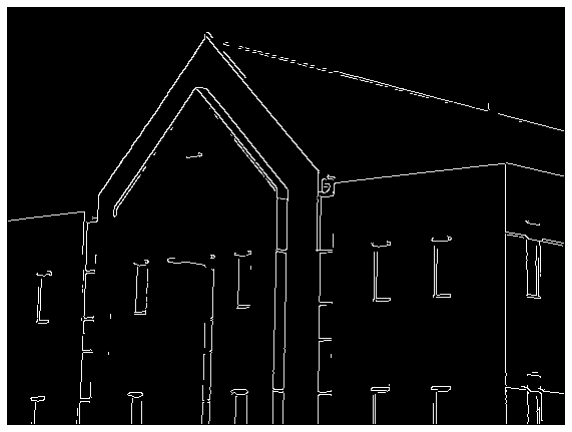

In [14]:
def nonmax(dang, mag):
    if dang[1, 1] == 1:
        maxmag = (mag[1, :]).max()
    elif dang[1, 1] == 2:
        maxmag = np.max((mag[0, 0], mag[1, 1], mag[2, 2]))
    elif dang[1, 1] == 3:
        maxmag = (mag[:, 1]).max()
    else :
        maxmag = np.max((mag[0, 2], mag[1, 1], mag[2, 0]))
 
    if mag[1, 1] >= maxmag: # bylo ===
    #val = maxmag
        val = mag[1,1]

    else:
        val = 0
    return val
 

DomGauss = cv2.GaussianBlur(I, (3, 3), 0)
DomSobelX = cv2.Sobel(DomGauss, cv2.CV_32F, 1, 0, 3)
DomSobelY = cv2.Sobel(DomGauss, cv2.CV_32F, 0, 1, 3)
 
DomSobelMag = cv2.sqrt(np.square(DomSobelX) + np.square(DomSobelY))
DomSobelAng = np.arctan2(DomSobelY, DomSobelX) * 180 / math.pi
 
ImageSize = I.shape
 
dAng = np.zeros(ImageSize)
dAng[(DomSobelAng >= -22.5) & (DomSobelAng < 22.5)] = 1
dAng[(DomSobelAng >= 157.5) | (DomSobelAng < -157.5)] = 1
dAng[(DomSobelAng >= 22.5) & (DomSobelAng < 67.5)] = 2
dAng[(DomSobelAng >= -157.5) & (DomSobelAng < -112.5)] = 2
dAng[(DomSobelAng >= 67.5) & (DomSobelAng < 112.5)] = 3
dAng[(DomSobelAng >= -112.5) & (DomSobelAng < -67.5)] = 3
dAng[(DomSobelAng >= 112.5) & (DomSobelAng < 157.5)] = 4
dAng[(DomSobelAng >= -67.5) & (DomSobelAng < -22.5)] = 4
 
gCanny = np.zeros(ImageSize)
 
for row in range(1, ImageSize[0] - 1):
    for col in range(1, ImageSize[1] - 1):
        dAngWindow = dAng[row - 1 : row + 2, col - 1 : col + 2]
        magWindow = DomSobelMag[row - 1 : row + 2, col - 1 : col + 2]
        gCanny[row, col] = nonmax(dAngWindow, magWindow)
 
 
thrH = 200
thrL = thrH / 2
 
gNH = (gCanny >= thrH)
gNL = ((gCanny >= thrL) & (gCanny < thrH))
 
figDom, axsDom = plt.subplots()
figDom.set_size_inches(10, 10)
 
axsDom.imshow(gNH, 'gray')
axsDom.axis('off')

gFinal = np.zeros(gNH.shape).astype('bool')
for row in range(1, ImageSize[0] - 1):
    for col in range(1, ImageSize[1] - 1):
        if gNH[row, col]:
            gFinal[row, col] = 1
            windowNH = gNH[row - 1: row + 2, col - 1: col + 2].copy()
            windowNL = gNL[row - 1: row + 2, col - 1: col + 2]
            windowNH[windowNL == 1] = 1
            gFinal[row - 1: row + 2, col - 1: col + 2] = windowNH
            
            
figDom, axsDom = plt.subplots()
figDom.set_size_inches(10, 10)
 
axsDom.imshow(gFinal, 'gray')
axsDom.axis('off')



## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

(-0.5, 556.5, 416.5, -0.5)

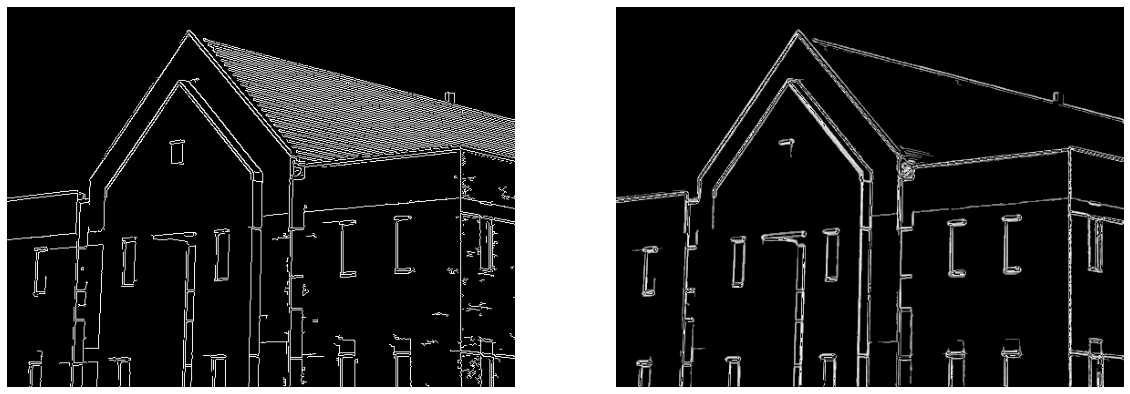

In [4]:
I = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)
C = cv2.Canny(I, 90, 180, None, 3, 1)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,10)

axs[0].imshow(C, 'gray')
axs[0].axis('off')
axs[1].imshow(I5, 'gray')
axs[1].axis('off')